In [1]:
from __future__ import print_function

In [2]:
#data handling and clustering
import pandas as pd
import numpy as np
import os.path
np.set_printoptions(precision=4,suppress=True)
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, fcluster, cophenet, set_link_color_palette
from scipy.spatial.distance import squareform
from fastcluster import linkage, pdist

# visualization
%matplotlib inline
import seaborn as sns

In [3]:
#Open proteomics data set
datadir = "c:/Users/kjnw534/OneDrive - AZCollaboration/Documents/General/metis-project/datafiles/"
proteomics_orig = pd.read_csv(os.path.join(datadir, "TCGA-BRCA-L4.csv"))

proteomics_orig.head()

,Sample_ID,Cancer_Type,Sample_Type,SetID,X1433EPSILON,X4EBP1,X4EBP1_pS65,X4EBP1_pT37T46,X53BP1,ACC_pS79,...,COG3,DUSP4,ERCC5,IGF1R_pY1135Y1136,IRF1,JAK2,P16INK4A,SHP2_pY542,PDL1,PARP1
0,TCGA-EW-A2FR-01A-21-A24A-20,BRCA,Primary,64,-0.101210,1.189400,-0.10401,1.42120,-0.088868,-0.257980,...,0.33568,1.12530,-0.170110,0.147550,0.080499,0.043623,0.60382,0.403630,0.146310,NaN
1,TCGA-EW-A2FS-01A-21-A24A-20,BRCA,Primary,64,-0.218400,-0.856650,-0.32188,-0.68654,-0.355140,-0.338300,...,0.25939,0.32797,-0.208860,0.225200,0.133370,-0.032932,0.22000,0.132680,0.078655,NaN
2,TCGA-EW-A2FW-01A-21-A24A-20,BRCA,Primary,64,0.197890,-0.229960,-0.34787,-0.55610,0.294950,0.864170,...,0.68060,1.90380,0.060178,0.015561,0.095061,-0.043102,-0.65529,-0.300890,-0.148050,NaN
3,TCGA-EW-A2FV-01A-21-A24A-20,BRCA,Primary,64,-0.101460,-0.635140,-0.70539,-0.34196,-0.795120,0.092919,...,0.16063,-0.23726,-0.157490,0.301190,-0.033752,-0.220960,0.34231,0.360780,0.268830,NaN
4,TCGA-EW-A1PC-01B-21-A24A-20,BRCA,Primary,64,-0.030366,0.016786,-0.44948,-0.24241,-0.344590,0.928000,...,-0.23874,0.12277,-0.411020,-0.071280,-0.164150,0.202370,0.70808,0.041365,0.152050,NaN


In [4]:
#Open gene symbol lookup table
gene_lookup = pd.read_excel(os.path.join(datadir,"BRCA_Nature/Gene_lookup.xlsx"))

gene_lookup.head()


,Input,Match type,Approved symbol,Approved name,Confidence,Count,HGNC ID,Location
0,ACC,Previous symbol,ACACA,acetyl-CoA carboxylase alpha,High,1,HGNC:84,17q12
1,ACC1,Synonyms,ACACA,acetyl-CoA carboxylase alpha,High,2,HGNC:84,17q12
2,ACC1,Synonyms,BCL2A1,BCL2 related protein A1,Low,2,HGNC:991,15q25.1
3,ACETYLATUBULINLYS40,Unmatched,ATAT1,alpha tubulin acetyltransferase 1,High,1,NaN,NaN
4,ACVRL1,Approved symbol,ACVRL1,activin A receptor like type 1,High,1,HGNC:175,12q13.13


In [5]:
#Open gene symbol consolidation lookup table
gene_consolidation_lookup = pd.read_excel(os.path.join(datadir,"TCGA-BRCA-L4_Gene_Lookup.xlsx"))

gene_consolidation_lookup.head()

,SetID,GeneID
0,ACC_pS79,ACC
1,ACC1,ACC1
2,ACETYLATUBULINLYS40,ACETYLATUBULINLYS40
3,ACVRL1,ACVRL1
4,ADAR1,ADAR1


In [6]:
#Write original column headers to a data frame
prot_headers =pd.DataFrame(proteomics_orig.columns.values)

prot_headers.columns=['Original']
#Merge consolidated values
prot_headers_consol = pd.merge(prot_headers, gene_consolidation_lookup, how = 'left', left_on = 'Original', right_on = 'SetID')

#Merge new values using original value (single match)
prot_headers = pd.merge(prot_headers, gene_lookup[gene_lookup.Confidence == 'High'], how='left', left_on='Original',
                        right_on='Input')

prot_headers_consol = pd.merge(prot_headers_consol, gene_lookup, how='left', left_on='GeneID', right_on='Input')

prot_headers.head()


,Original,Input,Match type,Approved symbol,Approved name,Confidence,Count,HGNC ID,Location
0,Sample_ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Cancer_Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sample_Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SetID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,X1433EPSILON,X1433EPSILON,Unmatched,YWHAE,14-3-3 protein epsilon,High,1.0,NaN,NaN


In [7]:
proteomics_renamed = proteomics_orig

#proteomics_renamed.columns = 
new_headers = prot_headers.loc[:,['Approved symbol']].values.flatten()
new_headers[0]='SampleID'
#new_headers

proteomics_renamed.columns = new_headers

proteomics_renamed.head()

,SampleID,nan,nan,nan,YWHAE,EIF4EBP1,nan,nan,TP53BP1,nan,...,COG3,DUSP4,ERCC5,nan,IRF1,JAK2,CDKN2A,nan,CD274,PARP1
0,TCGA-EW-A2FR-01A-21-A24A-20,BRCA,Primary,64,-0.101210,1.189400,-0.10401,1.42120,-0.088868,-0.257980,...,0.33568,1.12530,-0.170110,0.147550,0.080499,0.043623,0.60382,0.403630,0.146310,NaN
1,TCGA-EW-A2FS-01A-21-A24A-20,BRCA,Primary,64,-0.218400,-0.856650,-0.32188,-0.68654,-0.355140,-0.338300,...,0.25939,0.32797,-0.208860,0.225200,0.133370,-0.032932,0.22000,0.132680,0.078655,NaN
2,TCGA-EW-A2FW-01A-21-A24A-20,BRCA,Primary,64,0.197890,-0.229960,-0.34787,-0.55610,0.294950,0.864170,...,0.68060,1.90380,0.060178,0.015561,0.095061,-0.043102,-0.65529,-0.300890,-0.148050,NaN
3,TCGA-EW-A2FV-01A-21-A24A-20,BRCA,Primary,64,-0.101460,-0.635140,-0.70539,-0.34196,-0.795120,0.092919,...,0.16063,-0.23726,-0.157490,0.301190,-0.033752,-0.220960,0.34231,0.360780,0.268830,NaN
4,TCGA-EW-A1PC-01B-21-A24A-20,BRCA,Primary,64,-0.030366,0.016786,-0.44948,-0.24241,-0.344590,0.928000,...,-0.23874,0.12277,-0.411020,-0.071280,-0.164150,0.202370,0.70808,0.041365,0.152050,NaN


In [8]:
#Transpose data to make it easier to join?
proteomics_renamed_T = proteomics_renamed.transpose()

proteomics_renamed_T.head()
print(proteomics_renamed.shape)

(901, 228)


In [9]:
#Import gene expression data
expr_orig = pd.read_csv(os.path.join(datadir, "BRCA_Nature/brca_tcga_pub_brca_tcga_pub_mrna_median_Zscores.txt"), sep='\t')

expr_orig.head()

,GENE_ID,COMMON,TCGA-A2-A0T2-01,TCGA-A2-A04P-01,TCGA-A1-A0SK-01,TCGA-A2-A0CM-01,TCGA-AR-A1AR-01,TCGA-B6-A0WX-01,TCGA-BH-A1F0-01,TCGA-B6-A0I6-01,...,TCGA-AO-A03R-01,TCGA-AO-A03T-01,TCGA-AR-A1AO-01,TCGA-A2-A0YT-01,TCGA-AO-A0J5-01,TCGA-A1-A0SP-01,TCGA-A8-A08S-01,TCGA-A8-A09E-01,TCGA-A8-A09K-01,TCGA-D8-A146-01
0,STUDY_ID,-,brca_tcga_pub,brca_tcga_pub,brca_tcga_pub,brca_tcga_pub,brca_tcga_pub,brca_tcga_pub,brca_tcga_pub,brca_tcga_pub,...,brca_tcga_pub,brca_tcga_pub,brca_tcga_pub,brca_tcga_pub,brca_tcga_pub,brca_tcga_pub,brca_tcga_pub,brca_tcga_pub,brca_tcga_pub,brca_tcga_pub
1,ABL1,25,-0.9394,0.8301,0.8606,-0.4412,0.6949,-0.4264,-0.5241,-1.5251,...,2.8206,0.4880,-0.6640,-0.4115,-0.7653,-1.0397,0.2455,1.1690,-0.1344,0.2479
2,ACACA,31,-0.1425,-0.4054,-1.0123,0.3399,-0.6480,-0.4845,1.2517,-1.7583,...,-1.0746,0.1433,-1.3599,1.6685,-2.0946,0.2472,3.3944,1.4501,-0.8886,-1.4123
3,ACVRL1,94,1.1439,0.6061,-1.6706,0.7632,1.9277,0.4213,2.4636,-0.4858,...,0.3576,-0.1232,1.5972,0.1313,0.7482,0.0341,0.4604,-0.4059,-1.4339,-0.3020
4,ADAR,103,-1.0462,-1.5385,-0.2771,2.7843,1.6505,1.3850,1.4887,-0.9525,...,-1.3922,-0.5328,0.0394,1.3647,0.2607,-0.8411,2.7382,3.5352,0.1046,0.5203


In [10]:
expr_samples = pd.DataFrame(expr_orig.columns)

prot_samples = pd.DataFrame(proteomics_renamed.SampleID.str[:15])#pd.DataFrame(
    #)
samples = pd.merge(expr_samples, prot_samples, how='inner', left_on=0, right_on='SampleID' )

print('Samples in expression data:',expr_samples[0].count(), '\nSamples in proteomics data:',prot_samples.SampleID.count(),
     '\nSamples in both data sets:',samples.SampleID.count())

samples.head()

Samples in expression data: 528 
Samples in proteomics data: 901 
Samples in both data sets: 416


,0,SampleID
0,TCGA-A2-A0T2-01,TCGA-A2-A0T2-01
1,TCGA-A2-A04P-01,TCGA-A2-A04P-01
2,TCGA-A1-A0SK-01,TCGA-A1-A0SK-01
3,TCGA-A2-A0CM-01,TCGA-A2-A0CM-01
4,TCGA-B6-A0WX-01,TCGA-B6-A0WX-01


In [11]:
#Determine which genes are in both data sets (not all genes are common because of the multiple synonyms for some genes)

expr_genes = pd.DataFrame(expr_orig.transpose().iloc[0])
prot_genes = pd.DataFrame(proteomics_orig.columns)
prot_genes.columns = ['SampleID']

#Use inner join with gene lists to get those genes that match both lists
all_genes = pd.merge(expr_genes, prot_genes, how='inner', left_on='GENE_ID', right_on='SampleID')

print('Number of genes:')
print('\tExpression:\t',expr_genes.GENE_ID.count())
print('\tProteomics:\t',prot_genes.SampleID.count())
print('\tBoth:\t\t',all_genes.GENE_ID.count())

#Reformat all_genes data frame for match
all_genes = all_genes.transpose()
#Move first row to column header
all_genes.columns = all_genes.iloc[0]
#Add descriptor columns for expression and proteomics data
all_genes['SampleID'] = 'SampleID'

Number of genes:
	Expression:	 195
	Proteomics:	 169
	Both:		 165


In [12]:
#Create expression data set for analysis with only those samples in both data sets

#Transpose loaded data so samples become rows
expr_t = expr_orig.transpose()

#Move first row to column header
gene_list = expr_t.iloc[0] #grab the first row for the header
expr_t = expr_t[1:] #take the data less the header row
expr_t.columns = gene_list #set the header row as the df header

#Move SampleID to first column
expr_t.index.name = 'SampleID'
expr_t.reset_index(inplace=True)

#Do inner join with sample data to create final expr_data set that only keeps samples that match both data sets
expr_data = pd.merge(expr_t, samples, how='inner', left_on = 'SampleID', right_on='SampleID')

#Remove STUDY_ID column as not needed
del expr_data['STUDY_ID']

#Keep columns that are listed in all_gene dataframe
matches = []
for x in expr_data.columns:
    if x in all_genes:
        matches.append(x)
expr_data = expr_data[matches]
#Reset gene_list to match column headers for gene expression data set
#gene_list = expr_data.columns

print('Samples in expression data:',expr_data.SampleID.count())
print('Genes in expression data:', len(expr_data.columns))

Samples in expression data: 416
Genes in expression data: 165


In [13]:
#Create proteomics data set that matches the genes and samples in the expression data set

#Create working copy for proteomics data
prot_data = proteomics_renamed

#Replace SampleID with shortened version
prot_data.SampleID = prot_data.SampleID.str[:15]

#Merge with Samples to only keep those samples match both data sets
prot_data = pd.merge(prot_data, samples, how='inner', left_on = 'SampleID', right_on='SampleID')

#Keep columns that are listed in all_gene dataframe
matches = []
for x in prot_data.columns:
    if x in all_genes:
        matches.append(x)
prot_data = prot_data[matches]

print('Samples in proteomics data:',prot_data.SampleID.count())
print('Genes in proteomics data:', len(prot_data.columns))


Samples in proteomics data: 416
Genes in proteomics data: 168


In [208]:
#Create new data frame based on ratio of expr:prot for each sample

#Use expression dataframe as starting point
expr = expr_data
expr = expr.set_index('SampleID')

#Use expr data set to create a data frame for the ratio data
df_ratio = expr
df_ratio.value = 0

#Create working version of proteomics data set
prot = prot_data
prot = prot.set_index('SampleID')
temp = []
for sample in expr_data.SampleID:
    for gene in expr.columns:
        try:
            ratio = float(expr.loc[sample,gene])/float(prot.loc[sample,gene])
        except:
            ratio = 'NaN'
        df_ratio.at[sample,gene] = ratio
        
print(df_ratio.head())

                    ABL1     ACACA   ACVRL1     ADAR      AKT1    ANXA1  \
SampleID                                                                  
TCGA-A2-A0T2-01  4.33343  -0.28321 -33.5356 -6.95519    4.0201 -7.82266   
TCGA-A2-A04P-01 -5.64348  -4.30023  1.77627 -31.9901  0.165972  3.50225   
TCGA-A1-A0SK-01 -9.10466   1.81758  162.557 -0.90921  -7.94598  1.73089   
TCGA-A2-A0CM-01  -2.6251   5.26569 -4.03681  4.42423  -28.8414  1.89001   
TCGA-B6-A0WX-01 -2.58315  0.900357  3.79721 -7.38745  -6.68569  1.95051   

                   ANXA7   AR ARAF    ARID1A  ...        TSC2     XBP1  \
SampleID                                      ...                        
TCGA-A2-A0T2-01  10.4499  NaN  NaN   8.65833  ...    -36.9702  15.0259   
TCGA-A2-A04P-01   7.7764  NaN  NaN   12.7512  ...    -14.7575 -68.7569   
TCGA-A1-A0SK-01  21.6131  NaN  NaN   1.41779  ...      2.5517  37.0395   
TCGA-A2-A0CM-01 -23.1147  NaN  NaN  0.197516  ...    0.294606 -5.92111   
TCGA-B6-A0WX-01 -2.64893  NaN 

In [212]:
df_ratio.to_excel('ratio.xlsx')


In [14]:
#Plot values for expression vs. proteomics for each sample
df_plot = pd.merge(prot_data, expr_data[:1000], how='inner', left_on='SampleID', right_on='SampleID', suffixes=('_Expr','_Prot'))
df_plot.head()

,SampleID,YWHAE_Expr,EIF4EBP1_Expr,TP53BP1_Expr,ACACA_Expr,AKT1_Expr,PRKAA1_Expr,AR_Expr,ASNS_Expr,ATM_Expr,...,TSC1_Prot,TSC2_Prot,XBP1_Prot,XRCC1_Prot,XRCC5_Prot,YBX1_Prot,YWHAB_Prot,YWHAE_Prot,YWHAZ_Prot,YY1AP1_Prot
0,TCGA-BH-A0B3-01,-0.029191,-0.284140,-0.72974,-0.084628,-0.188810,-0.26326,-0.29338,0.867710,-0.24204,...,-1.5375,1.0133,-1.1061,-0.1072,-0.7075,1.2941,-1.0654,-0.1770,3.5443,3.2078
1,TCGA-A1-A0SJ-01,0.236960,0.042512,-0.54751,0.532470,0.079631,-0.32145,0.86044,0.076732,0.18670,...,-1.2466,-0.1402,0.8221,-1.1492,0.2991,0.1145,4.0458,-0.4936,2.1852,-0.4189
2,TCGA-BH-A0AZ-01,0.354190,-0.260010,-0.52883,0.227280,0.243360,-0.11199,0.63135,-0.701000,-0.16203,...,-0.1233,1.8647,0.4349,0.7682,-0.4010,-0.5841,0.0419,-1.1713,-0.5597,0.6567
3,TCGA-BH-A0BJ-01,0.224180,0.166710,0.60446,0.473360,0.268010,0.32174,1.67520,-0.038062,0.94426,...,0.2544,0.9592,0.2207,-0.2449,0.9820,0.0970,-0.2559,0.5927,-0.1117,0.7221
4,TCGA-BH-A0BS-01,0.125850,0.202850,0.20434,1.016500,0.555120,-0.22136,1.53250,-0.566990,0.47109,...,-2.6525,0.9547,-0.2327,1.5286,-0.6857,-1.3940,0.9247,0.1814,0.6255,1.5775


In [15]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

In [62]:
plot_genes = []
filter_genes = []
print(all_genes.columns[:1])
for gene in all_genes.columns[:5]:
    pair = (gene + '_Expr',gene + '_Prot')
    plot_genes.append(pair)
    filter_genes.append(gene + '_Expr')
    filter_genes.append(gene + '_Prot')

print(plot_genes)
gene_plot = df_plot[filter_genes]

gene_plot.head()

Index([u'ABL1'], dtype='object', name=u'GENE_ID')
[('ABL1_Expr', 'ABL1_Prot'), ('ACACA_Expr', 'ACACA_Prot'), ('ACVRL1_Expr', 'ACVRL1_Prot'), ('ADAR_Expr', 'ADAR_Prot'), ('AKT1_Expr', 'AKT1_Prot')]


,ABL1_Expr,ABL1_Prot,ACACA_Expr,ACACA_Prot,ACVRL1_Expr,ACVRL1_Prot,ADAR_Expr,ADAR_Prot,AKT1_Expr,AKT1_Prot
0,0.038367,0.0173,-0.084628,-0.0836,0.117820,1.0008,0.50182,3.4983,-0.188810,0.0476
1,-0.247890,-1.9118,0.532470,-1.4909,0.105520,0.1629,-0.33351,-0.8839,0.079631,-0.1807
2,0.039160,1.7817,0.227280,-0.4732,0.306770,-0.4045,-0.18181,1.6992,0.243360,2.2717
3,0.124890,0.0776,0.473360,-0.1789,-0.081287,1.3996,-0.18497,1.2921,0.268010,-0.1731
4,0.097712,-0.6403,1.016500,0.7142,0.067388,-0.4776,0.12407,2.0628,0.555120,0.6940


In [56]:
print(gene_pairs)

for first, second in zip(gene_pairs, gene_pairs[1:]):
    print(first, second)

Index([  u'ABL1_Expr',   u'ABL1_Prot',  u'ACACA_Expr',  u'ACACA_Prot',
       u'ACVRL1_Expr', u'ACVRL1_Prot',   u'ADAR_Expr',   u'ADAR_Prot',
         u'AKT1_Expr',   u'AKT1_Prot'],
      dtype='object')
ABL1_Expr ABL1_Prot
ABL1_Prot ACACA_Expr
ACACA_Expr ACACA_Prot
ACACA_Prot ACVRL1_Expr
ACVRL1_Expr ACVRL1_Prot
ACVRL1_Prot ADAR_Expr
ADAR_Expr ADAR_Prot
ADAR_Prot AKT1_Expr
AKT1_Expr AKT1_Prot


AttributeError: 'Series' object has no attribute 'strip'

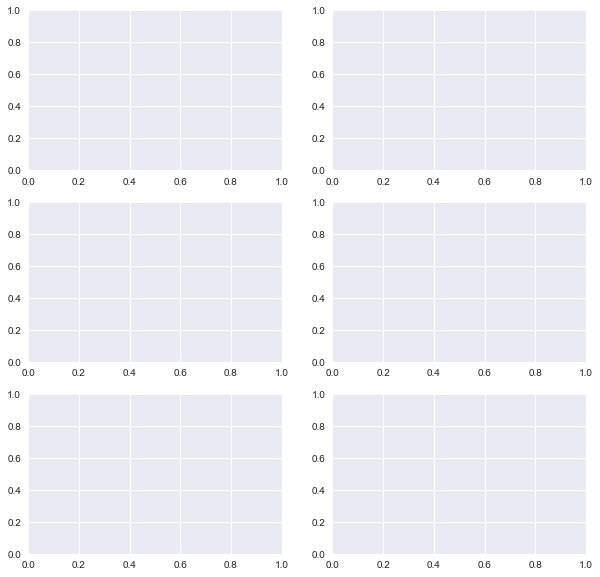

In [112]:
from itertools import combinations
import matplotlib.pyplot as plt

#pairs = list(combinations(gene_plot.columns, 2))
j = 311
fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(10, 10))
for i, pair in enumerate(plot_genes):
    x = gene_plot[pair[0]].strip()
    y = gene_plot[pair[1]].strip()
    #print(x)
    #plt.scatter(x,y)
    #plt.plot(x,y)
    #d = d.dropna()
    #print(d)
    ax = axes[i // 3, i % 3]
    d.plot.scatter(x,y, ax=ax)

#fig.tight_layout()
plt.show()